# 2  H SAF Root-zone Soil wetness index products
## 2.1  Overview

The root-zone soil wetness index (SWI) products are available in Near Real-Time (NRT) or as Climate Data Record (CDR) daily products. The main difference between the two product groups is that, NRT RSM is available within 12-36 hours (typically < 24 hours) of the analysis time. The CDR RSM represents a consistent long-term data record, which is updated annually (currently 1992-2016). The following table summarises the different products:   

<h2 style='padding: 10px'>NRT and data record RSM products</h2><table class='table table-striped'> <thead> <tr> <th>Product name</th> <th>Type</th> <th>Period</th> <th>Obs assimilated</th> <th>DA system</th> <th>Resolution</th> <th>QC flags</th> </tr> </thead> <tbody> <tr> <th scope='row'>H14</th> <td>NRT</td> <td>2012 onwards</td> <td> ASCAT-A/B SSM products </td> <td> Regular updates of ECMWF LDAS (38R1-45R1) </td> <td> 25 km </td> <th> Yes since 4/10/18 (1=normal, 2=frozen risk, 3=outide nominal range)  </th> </tr> <tr> <th scope='row'>H27</th> <td>Data record</td> <td>1992-2014</td> <td> ERS 1/2 (1992-2006) and ASCAT-A (2007-2014) reprocessed SSM </td> <td> 41R1 of ECMWF LDAS </td>  <td>16 km</td> <th> None  </th> </tr> <tr> <th scope='row'>H140</th> <td>Data record</td> <td>2015-2016</td> <td> ASCAT-A (2015-2016) reprocessed SSM </td> <td> 43R3 of ECMWF LDAS </td>  <td>16 km</td> <th> None  </th> </tr> </tbody> </table>

Both NRT and data record products are provided in grib format on reduced Gaussian grids. While this is an efficient way to store the data it is not optimal for plotting. A conversion is generally required from reduced Gaussian to regular lat/lon and from grib format to netCDF format. This can be done using various software, such as NCAR command language (NCL) and climate data operators (CDO). The following examples use the CDO tool, which is free to download from:
https://code.mpimet.mpg.de/projects/cdo


## 2.2  Downloading and visualizing the H14 NRT root-zone soil wetness index product
In this exercise we will

-  Download the grib files from H-SAF ftp
-  Produce regular lat/lon netCDF files over a particular region
-  Read the data in python
-  Plot the data in python




### 2.2.1 Downloading the grib files from H-SAF ftp
Each of you should have been given a username and password for reading data from the H-SAF ftp.
To download the example file (H14 for 01/11/2018), one can use software such as "filezilla" or from the command line:

ftp ftphsaf.meteoam.it

username: (type your username)

password: (type your password)

cd /products/h14/h14_cur_mon_grib

get h14_20181101_0000.grib.bz2

exit

bzip2 -d h14_20181101_0000.grib.bz2

### 2.2.2 Producing regular lat/lon netCDF files over a particular region

In the terminal, we will convert the grib file from reduced Gaussian to regular lat/lon. Firstly we need to know the number of regular latitude points correspoding to the linear reduced Gaussian grid (T799~N400), which can be found at:
https://www.ecmwf.int/en/forecasts/documentation-and-support/gaussian_n400

Given there are 1600 regular latitude points (and 800 longitude points), we can now convert our reduced Gaussian grid to regular lat/lon. We can then extract the Italian domain (lon0=5, lon1=19, lat0=36, lat1=48):

module load cdo
cdo -R remapcon,r1600x800 -setgridtype,regular h14_20181101_0000.grib h14_2018110100_r.grib
cdo -f nc copy h14_2018110100_r.grib h14_2018110100.nc # convert to netcdf 
cdo -sellonlatbox,5,19,36,48 h14_2018110100.nc h14_2018110100_Italy.nc #Extract italian domain


### 2.2.3 Reading the data in python

In [5]:
import os
from netCDF4 import Dataset 
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap 
import numpy as np

In [11]:
# Read in an example soil wetness index netcdf file into a Dataset object
SM_file = os.path.join(os.getcwd(), "data", "h14_2018110100_italy.nc")
SM = Dataset(SM_file)
print(SM.variables)

OrderedDict([(u'lon', <type 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (62,)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'lat', <type 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (53,)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'depth', <type 'netCDF4._netCDF4.Variable'>
float64 depth(depth)
    long_name: depth_below_land
    units: cm
    positive: down
    axis: Z
    bounds: depth_bnds
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'depth_bnds', <type 'netCDF4._netCDF4.Variable'>
float64 depth_bnds(depth, bnds)
unlimited dimensions: 
current shape = (1, 2)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'time', <type 

In [12]:
# Read the longitude, latitude and soil wetness index arrays for the each layer  
lon = SM.variables["lon"][:]
lat = SM.variables["lat"][:]
SWI_l1 = SM.variables["var40"][:] # 1st layer (0-7 cm depth)
SWI_l2 = SM.variables["var41"][:] # 2nd layer (7-21 cm depth)
SWI_l3 = SM.variables["var42"][:] # 3rd layer (21-100 cm depth)
SWI_l4 = SM.variables["var43"][:] # 4th layer (100-289 cm)

# Quality control flag (1=normal, 2=risk of frozen conditions, 3=outside nominal range)
qc = SM.variables["var200"][:]

# Calculate the depth integrated root-zone soil wetness index (layers 1-3)
SWI_RZ = (SWI_l1*0.07) + (SWI_l2*0.21) + (SWI_l3*0.72)

### 2.2.3 Plotting the data with basemap

In [13]:
# Create a meshgrid of the latitude and longitude values 
lon_grid, lat_grid = np.meshgrid(lon, lat)

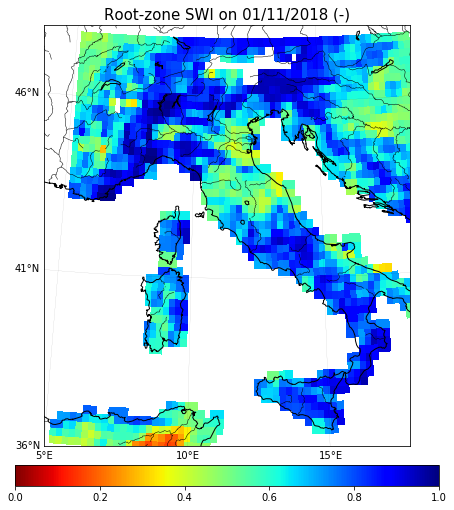

In [15]:
# Create figure and axes instances
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# Define the basemap projection e.g. equal area projection centred on (42 lat,12 lon)
m = Basemap(projection='aea',llcrnrlon=5.0,llcrnrlat=36.0,urcrnrlon=19.0,urcrnrlat=48.0,\
            lon_0=12.0,lat_0=42.0,resolution='i')

# Draw the map features:
m.drawcoastlines()
m.drawrivers()

# Draw parallels and meridians and label them on the left and bottom axes:
m.drawparallels(np.arange(36.,48.,5.0),labels=[True,False,False,False],linewidth=0.1)
m.drawmeridians(np.arange(5.,19.,5.0),labels=[False,False,False,True],linewidth=0.1)

# Transform the longitude and latitude values onto the basemap projection
x,y = m(lon_grid, lat_grid)

# Apply the mask to the data to remove SM where there is a risk of frozen conditions 
# or outside nominal range:

mask = (qc == 2.0) | (qc==3.0)

# Reshape the mask and data to the lat lon grid
mask = mask.reshape(len(lat),len(lon))
SWI_RZ = SWI_RZ.reshape(len(lat),len(lon))

# Mask the data
maskeddata = np.ma.masked_where(mask, SWI_RZ)

# Specify the plot params
cmin = 0.0
cmax = 1.0
cmap = plt.cm.jet_r
latlon = False

# Plot the data using pcolormesh
cs = m.pcolormesh(x, y, maskeddata, cmap=cmap, latlon=latlon,
                  vmin=cmin, vmax=cmax)

# Add a title
plt.title('Root-zone SWI on 01/11/2018 (-)', fontsize=15)

# Display the colour bar:
cbar = plt.colorbar(cs, fraction=0.046, 
                    pad=0.04, orientation='horizontal')

# Show the plot
plt.savefig('SWI_Italy_11_01_2018.png', dpi=300) 

# Show the plot
plt.show() 
plt.close()

## 2.2.3 Exercise:

- From the nc file (h14_2018110100.nc), use cdo to extract one of the following domains:

 Albania:       lon0=15,      lon1=25,      lat0=40,      lat1=45,
 
 India:         lon0=73,       lon1=77,      lat0=15,      lat1=21,
 
 France:        lon0=2,       lon1=6,       lat0=46,      lat1=52,
 
 Spain:         lon0=-5,      lon1=0,       lat0=40,      lat1=45,
 
 Morocco:       lon0=-7,      lon1=-4,      lat0=33,      lat1=37,
 

- Read and plot the root-zone soil wetness index for the domain you extracted


## 2.3  Downloading and visualizing the H27 root-zone soil wetness index data record
In this exercise I will show you how to

-  Stack multiple netcdf files in a time series
-  plot a time series for a single point
-  Perform some basic statistics (mean, standard deviation)

### 2.3.1 Downloading the grib files from H-SAF ftp 

The h27 data record can be found in "/products/h27" in the H-SAF ftp. Multiple daily files can be downloaded via the ftp.

### 2.3.2 Producing regular lat/lon netCDF files over a particular region in a time series

In order to convert the reduced Gaussian file to regular lat/lon we need to know the number of latitude points at the equator for the linear reduced Gaussian grid (T1279~N640), which can be found at:
https://www.ecmwf.int/en/forecasts/documentation-and-support/gaussian_n640
Given there are 2560 regular latitude (and 800 longitude points), we can convert our reduced Gaussian grid to regular lat/lon for any particular date (YYYYMMDD):

cdo -R remapcon,r2560x1280 -setgridtype,regular h27_YYYYMMDD00_T1279.grib h27_YYYYMMDD_00_r.grib

We can then extract the netCDF files for a particular domain (as described in Section 2.2.2)
A time series file can be created by stacking multiple daily netcdf files, for example using cdo mergetime:

cdo mergetime h27\*.nc time_series.nc


### 2.3.3 Download preprocessed time series

A yearly time series for 2014 has already been created for Morocco.


### 2.3.4 Reading the data in python

In [16]:
# Import the relevant libraries, including Pandas for time series plotting
from netCDF4 import Dataset 
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap 
import numpy as np 
import pandas as pd 


In [18]:
# A time series for 2014 has been created for each of the basins. 
# Let's read the example file for Morocco:

SM_file = os.path.join(os.getcwd(), "data", "h27_2014_morocco.nc")
SM_h27 = Dataset(SM_file)
print(SM_h27.variables)

OrderedDict([(u'lon', <type 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (21,)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'lat', <type 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (28,)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'time', <type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 2014-1-1 00:00:00
    calendar: proleptic_gregorian
    axis: T
unlimited dimensions: time
current shape = (365,)
filling on, default _FillValue of 9.96920996839e+36 used
), (u'var40', <type 'netCDF4._netCDF4.Variable'>
float32 var40(time, lat, lon)
    code: 40
    table: 228
    _FillValue: -9e+33
    missing_value: -9e+33
unlimited dimensions: time
current sha

In [20]:
# Read in the different layers

SWI_l1 = SM_h27.variables["var40"][:] # 1st layer (0-7 cm depth)
SWI_l2 = SM_h27.variables["var41"][:] # 2nd layer (7-21 cm depth)
SWI_l3 = SM_h27.variables["var42"][:] # 3rd layer (21-100 cm depth)
SWI_l4 = SM_h27.variables["var43"][:] # 4th layer (100-289 cm)

# Calculate the depth integrated root-zone soil wetness index (layers 1-3)
SWI_RZ = (SWI_l1*0.07) + (SWI_l2*0.21) + (SWI_l3*0.72)
print(np.shape(SWI_RZ))

(365, 28, 21)


### 2.3.5 Calculate some statistics

In [22]:
# Now calculate the domain averaged time series:
SWI_RZ_Mean = SWI_RZ.reshape(365, 28*21).mean(axis=1)
print(np.shape(SWI_RZ_Mean))

# Now calculate the annual maximum and minimum values:
SWI_RZ_Max = SWI_RZ.max(axis=0)
print(np.shape(SWI_RZ_Max))

SWI_RZ_Min = SWI_RZ.min(axis=0)
print(np.shape(SWI_RZ_Min))

# Now calculate the standard deviation:
SWI_RZ_std = SWI_RZ.std(axis=0)

(365,)
(28, 21)
(28, 21)


### 2.3.6 Plotting a time series in python

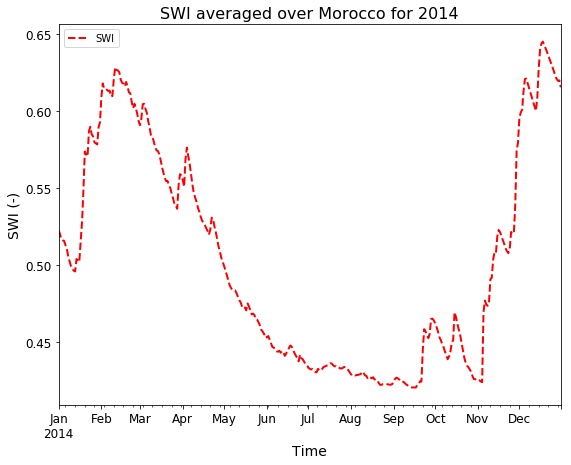

In [23]:
# Create a Pandas time series:
data_range = pd.date_range('2014-01-01', '2014-12-31',freq='D')

# Store the area averaged root-zone soil moisture as a data series:
SWI_time_series = pd.Series(SWI_RZ_Mean, data_range)            

# Create a new Figure for the data plot:
fig, axes = plt.subplots(nrows=1, ncols=1);        
fig.set_figheight(7);
fig.set_figwidth(9);

# Plot the data series
SWI_time_series.plot(ax=axes, linewidth=2, linestyle='--', color='r', label='SWI')
axes.set_title('SWI averaged over Morocco for 2014',fontsize=16);
axes.set_ylabel('SWI (-)', fontsize=14);
axes.set_xlabel('Time', fontsize=14);

# Specify the size of the axis ticks and labels
axes.tick_params(axis='y', labelsize=12); 
axes.tick_params(axis='x', labelsize=12);        

# Display the legend
handles, labels = axes.get_legend_handles_labels()
legend = plt.legend(handles,labels)

# Show the plot
plt.show()
plt.close()

### 2.3.5 Exercises

-  Extract and plot the area averaged root-zone SWI for 2014 for one of the other domains listed in 2.2.3

-  Plot a map of the 2014 maximum SWI values over the domain. Then plot the minimum values. 